# Data Exploration and Feature Engineering

This notebook covers:
1. Data understanding and exploration
2. Data quality assessment
3. Exploratory data analysis
4. Feature engineering and aggregation to provider level


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Loading


In [2]:
# Define data path
data_path = Path('../data')

# Load all datasets
print("Loading datasets...")
beneficiary_df = pd.read_csv(data_path / 'Train_Beneficiarydata-1542865627584.csv')
inpatient_df = pd.read_csv(data_path / 'Train_Inpatientdata-1542865627584.csv')
outpatient_df = pd.read_csv(data_path / 'Train_Outpatientdata-1542865627584.csv')
labels_df = pd.read_csv(data_path / 'Train-1542865627584.csv')

print("Data loaded successfully!")
print(f"\nBeneficiary data shape: {beneficiary_df.shape}")
print(f"Inpatient data shape: {inpatient_df.shape}")
print(f"Outpatient data shape: {outpatient_df.shape}")
print(f"Labels data shape: {labels_df.shape}")

# Display .info() for all datasets
print("\n" + "=" * 60)
print("BENEFICIARY DATA INFO")
print("=" * 60)
beneficiary_df.info()

print("\n" + "=" * 60)
print("INPATIENT DATA INFO")
print("=" * 60)
inpatient_df.info()

print("\n" + "=" * 60)
print("OUTPATIENT DATA INFO")
print("=" * 60)
outpatient_df.info()

print("\n" + "=" * 60)
print("LABELS DATA INFO")
print("=" * 60)
labels_df.info()


Loading datasets...
Data loaded successfully!

Beneficiary data shape: (138556, 25)
Inpatient data shape: (40474, 30)
Outpatient data shape: (517737, 27)
Labels data shape: (5410, 2)

BENEFICIARY DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 

## 2. Data Granularity Explanation

### Understanding the Data Structure

**Data Granularity Levels:**

1. **Beneficiary-Level Data** (`Train_Beneficiarydata.csv`):
   - One row per beneficiary (patient)
   - Contains demographics, coverage information, and chronic conditions
   - Unique identifier: `BeneID`
   - Granularity: Patient-level

2. **Claim-Level Data** (`Train_Inpatientdata.csv` and `Train_Outpatientdata.csv`):
   - One row per claim (each claim represents a service or set of services)
   - Contains financial details, procedures, diagnoses, physicians involved
   - Links to beneficiaries via `BeneID`
   - Links to providers via `Provider`
   - Granularity: Claim-level (multiple claims per beneficiary, multiple claims per provider)

3. **Provider-Level Labels** (`Train_labels.csv`):
   - One row per provider
   - Contains fraud label: `PotentialFraud` (Yes/No)
   - Unique identifier: `Provider`
   - Granularity: Provider-level (this is our **target variable**)

### Why Aggregation to Provider Level is Required

- Our target variable (`PotentialFraud`) is at the **provider level**, meaning each provider has a single fraud label (fraudulent or not)
- However, our input data is at the **claim level** (multiple claims per provider)
- Therefore, we must **aggregate** claim-level features up to the provider level to create one feature vector per provider
- This aggregation allows us to:
  - Summarize provider behavior patterns (e.g., total claims, average claim amount)
  - Capture provider characteristics (e.g., number of unique beneficiaries, diagnosis diversity)
  - Create provider-level statistics that can be used for fraud detection

### Preventing Data Leakage

**Critical requirement:** Each provider must appear in **only one** split (train, validation, or test). This is because:
- If the same provider appears in multiple splits, the model could "memorize" patterns from training and falsely appear to perform well on test data
- Provider-level split ensures true generalization to unseen providers
- We use stratified splitting on provider IDs to maintain class distribution while preventing leakage


In [3]:
# Examine labels distribution (target variable)
print("=" * 60)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(labels_df['PotentialFraud'].value_counts())
print(f"\nFraud rate: {(labels_df['PotentialFraud'] == 'Yes').sum() / len(labels_df) * 100:.2f}%")
print(f"Class imbalance ratio: {(labels_df['PotentialFraud'] == 'No').sum() / (labels_df['PotentialFraud'] == 'Yes').sum():.2f}:1")


TARGET VARIABLE DISTRIBUTION
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Fraud rate: 9.35%
Class imbalance ratio: 9.69:1


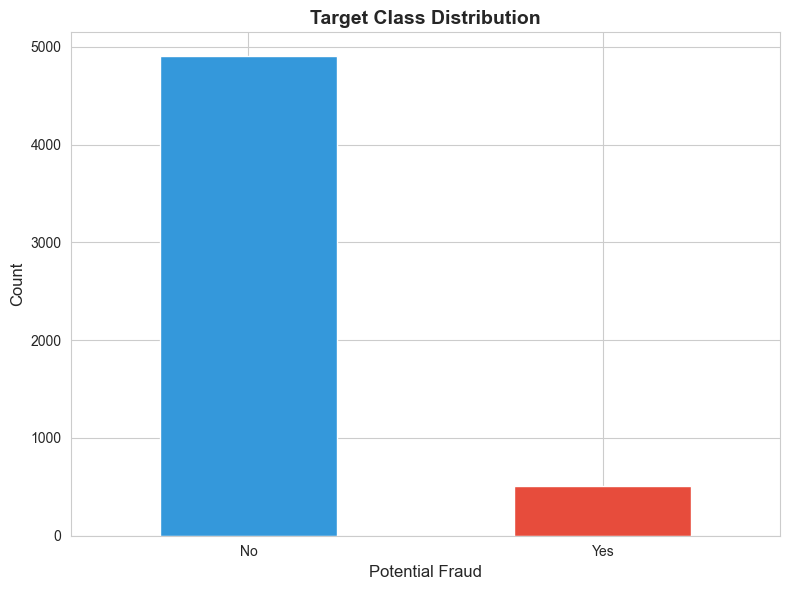

In [4]:
# Visualize target distribution
plt.figure(figsize=(8, 6))
labels_df['PotentialFraud'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Target Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Potential Fraud', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
# Examine structure of each dataset
print("=" * 60)
print("BENEFICIARY DATA")
print("=" * 60)
print(f"Columns: {list(beneficiary_df.columns)}")
print(f"\nFirst few rows:")
print(beneficiary_df.head())
print(f"\nData types:")
print(beneficiary_df.dtypes)
print(f"\nBasic statistics:")
print(beneficiary_df.describe())


BENEFICIARY DATA
Columns: ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

First few rows:
      BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   
2  BENE11003  1936-08-01  NaN       1     1                     0     52   
3  BENE11004  1922-07-01  NaN       1     1                     0     39   
4  BENE11005  1935-09-01  NaN       1   

In [6]:
# Examine inpatient data
print("=" * 60)
print("INPATIENT DATA")
print("=" * 60)
print(f"Columns: {list(inpatient_df.columns)}")
print(f"\nFirst few rows:")
print(inpatient_df.head())
print(f"\nData types:")
print(inpatient_df.dtypes)


INPATIENT DATA
Columns: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']

First few rows:
      BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PR

In [7]:
# Examine outpatient data
print("=" * 60)
print("OUTPATIENT DATA")
print("=" * 60)
print(f"Columns: {list(outpatient_df.columns)}")
print(f"\nFirst few rows:")
print(outpatient_df.head())
print(f"\nData types:")
print(outpatient_df.dtypes)


OUTPATIENT DATA
Columns: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode']

First few rows:
      BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed Attendin

## 3. Data Quality Assessment


In [8]:
# Check for missing values in all datasets
def check_missing_values(df, df_name):
    """Check and report missing values in a dataframe"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing Count': missing.values,
        'Missing Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n{df_name} - Missing Values:")
        print("=" * 60)
        print(missing_df.to_string(index=False))
    else:
        print(f"\n{df_name} - No missing values found!")
    
    return missing_df

# Check all datasets
beneficiary_missing = check_missing_values(beneficiary_df, "BENEFICIARY DATA")
inpatient_missing = check_missing_values(inpatient_df, "INPATIENT DATA")
outpatient_missing = check_missing_values(outpatient_df, "OUTPATIENT DATA")
labels_missing = check_missing_values(labels_df, "LABELS DATA")



BENEFICIARY DATA - Missing Values:
Column  Missing Count  Missing Percentage
   DOD         137135           98.974422

INPATIENT DATA - Missing Values:
             Column  Missing Count  Missing Percentage
 ClmProcedureCode_6          40474          100.000000
 ClmProcedureCode_5          40465           99.977764
 ClmProcedureCode_4          40358           99.713396
 ClmProcedureCode_3          39509           97.615753
ClmDiagnosisCode_10          36547           90.297475
     OtherPhysician          35784           88.412314
 ClmProcedureCode_2          35020           86.524683
 ClmProcedureCode_1          17326           42.807728
 OperatingPhysician          16644           41.122696
 ClmDiagnosisCode_9          13497           33.347334
 ClmDiagnosisCode_8           9942           24.563918
 ClmDiagnosisCode_7           7258           17.932500
 ClmDiagnosisCode_6           4838           11.953353
 ClmDiagnosisCode_5           2894            7.150269
 ClmDiagnosisCode_4  

In [9]:
# Check for duplicates
print("=" * 60)
print("DUPLICATE CHECK")
print("=" * 60)
print(f"Beneficiary duplicates: {beneficiary_df.duplicated().sum()}")
print(f"Inpatient duplicates: {inpatient_df.duplicated().sum()}")
print(f"Outpatient duplicates: {outpatient_df.duplicated().sum()}")
print(f"Labels duplicates: {labels_df.duplicated().sum()}")

# Check for duplicate BeneIDs in beneficiary data
print(f"\nDuplicate BeneIDs in beneficiary data: {beneficiary_df['BeneID'].duplicated().sum()}")
print(f"Duplicate Providers in labels data: {labels_df['Provider'].duplicated().sum()}")


DUPLICATE CHECK
Beneficiary duplicates: 0
Inpatient duplicates: 0
Outpatient duplicates: 0
Labels duplicates: 0

Duplicate BeneIDs in beneficiary data: 0
Duplicate Providers in labels data: 0


## 3.5 Invalid Values Check


In [10]:
# Check for invalid values in claims data
print("=" * 60)
print("INVALID VALUES CHECK")
print("=" * 60)

# Check for negative claim amounts/reimbursements
financial_cols_inpatient = [col for col in inpatient_df.columns 
                           if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct', 'reimb'])]

financial_cols_outpatient = [col for col in outpatient_df.columns 
                            if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct', 'reimb'])]

print("\n1. Checking for negative financial values:")
invalid_negative = {}
for col in financial_cols_inpatient:
    if pd.api.types.is_numeric_dtype(inpatient_df[col]):
        negative_count = (inpatient_df[col] < 0).sum()
        if negative_count > 0:
            invalid_negative[f'Inpatient_{col}'] = negative_count
            print(f"   WARNING: {col} in inpatient data has {negative_count} negative values")

for col in financial_cols_outpatient:
    if pd.api.types.is_numeric_dtype(outpatient_df[col]):
        negative_count = (outpatient_df[col] < 0).sum()
        if negative_count > 0:
            invalid_negative[f'Outpatient_{col}'] = negative_count
            print(f"   WARNING: {col} in outpatient data has {negative_count} negative values")

if not invalid_negative:
    print("   ✓ No negative financial values found")

# Check for 0 or negative Length of Stay (LOS) in inpatient data
print("\n2. Checking for invalid Length of Stay (0-LOS):")
if 'AdmissionDt' in inpatient_df.columns and 'DischargeDt' in inpatient_df.columns:
    # Convert dates to datetime
    inpatient_df['AdmissionDt_parsed'] = pd.to_datetime(inpatient_df['AdmissionDt'], errors='coerce')
    inpatient_df['DischargeDt_parsed'] = pd.to_datetime(inpatient_df['DischargeDt'], errors='coerce')
    
    # Calculate LOS in days
    inpatient_df['LOS_days'] = (inpatient_df['DischargeDt_parsed'] - inpatient_df['AdmissionDt_parsed']).dt.days
    
    # Check for 0 or negative LOS
    invalid_los = (inpatient_df['LOS_days'] <= 0).sum()
    zero_los = (inpatient_df['LOS_days'] == 0).sum()
    negative_los = (inpatient_df['LOS_days'] < 0).sum()
    
    print(f"   Total invalid LOS (<=0): {invalid_los}")
    print(f"   Zero LOS: {zero_los}")
    print(f"   Negative LOS: {negative_los}")
    
    if invalid_los > 0:
        print(f"   WARNING: {invalid_los} records have invalid LOS")
    else:
        print("   ✓ No invalid LOS values found")
    
    # Also check for very long LOS (potential outliers)
    very_long_los = (inpatient_df['LOS_days'] > 365).sum()
    if very_long_los > 0:
        print(f"   NOTE: {very_long_los} records have LOS > 365 days (potential outliers)")
else:
    print("   AdmissionDt or DischargeDt columns not found - skipping LOS check")

# Check for invalid claim date ranges
print("\n3. Checking for invalid claim date ranges:")
if 'ClaimStartDt' in inpatient_df.columns and 'ClaimEndDt' in inpatient_df.columns:
    inpatient_df['ClaimStartDt_parsed'] = pd.to_datetime(inpatient_df['ClaimStartDt'], errors='coerce')
    inpatient_df['ClaimEndDt_parsed'] = pd.to_datetime(inpatient_df['ClaimEndDt'], errors='coerce')
    invalid_dates_ip = ((inpatient_df['ClaimEndDt_parsed'] < inpatient_df['ClaimStartDt_parsed']).sum())
    print(f"   Inpatient claims with end date before start date: {invalid_dates_ip}")

if 'ClaimStartDt' in outpatient_df.columns and 'ClaimEndDt' in outpatient_df.columns:
    outpatient_df['ClaimStartDt_parsed'] = pd.to_datetime(outpatient_df['ClaimStartDt'], errors='coerce')
    outpatient_df['ClaimEndDt_parsed'] = pd.to_datetime(outpatient_df['ClaimEndDt'], errors='coerce')
    invalid_dates_op = ((outpatient_df['ClaimEndDt_parsed'] < outpatient_df['ClaimStartDt_parsed']).sum())
    print(f"   Outpatient claims with end date before start date: {invalid_dates_op}")

print("\nInvalid values check completed!")


INVALID VALUES CHECK

1. Checking for negative financial values:
   ✓ No negative financial values found

2. Checking for invalid Length of Stay (0-LOS):
   Total invalid LOS (<=0): 605
   Zero LOS: 605
   Negative LOS: 0

3. Checking for invalid claim date ranges:
   Inpatient claims with end date before start date: 0
   Outpatient claims with end date before start date: 0

Invalid values check completed!


## 4. Understanding Data Relationships


In [11]:
# Check how datasets are connected
print("=" * 60)
print("DATA RELATIONSHIPS")
print("=" * 60)

# Check common columns between datasets
print("\n1. Common identifiers:")
print(f"   - BeneID: Links patients (beneficiaries) to claims")
print(f"   - Provider: Links claims to fraud labels")

# Check overlap of BeneIDs
unique_beneficiary_ids = set(beneficiary_df['BeneID'].unique())
unique_inpatient_ids = set(inpatient_df['BeneID'].unique())
unique_outpatient_ids = set(outpatient_df['BeneID'].unique())

print(f"\n2. Beneficiary ID overlaps:")
print(f"   - Unique beneficiaries in beneficiary data: {len(unique_beneficiary_ids)}")
print(f"   - Unique beneficiaries in inpatient data: {len(unique_inpatient_ids)}")
print(f"   - Unique beneficiaries in outpatient data: {len(unique_outpatient_ids)}")
print(f"   - Beneficiaries in both inpatient and outpatient: {len(unique_inpatient_ids & unique_outpatient_ids)}")

# Check Provider overlaps
unique_providers_labels = set(labels_df['Provider'].unique())
unique_providers_inpatient = set(inpatient_df['Provider'].unique())
unique_providers_outpatient = set(outpatient_df['Provider'].unique())

print(f"\n3. Provider overlaps:")
print(f"   - Unique providers in labels: {len(unique_providers_labels)}")
print(f"   - Unique providers in inpatient data: {len(unique_providers_inpatient)}")
print(f"   - Unique providers in outpatient data: {len(unique_providers_outpatient)}")
print(f"   - Providers in both inpatient and outpatient: {len(unique_providers_inpatient & unique_providers_outpatient)}")


DATA RELATIONSHIPS

1. Common identifiers:
   - BeneID: Links patients (beneficiaries) to claims
   - Provider: Links claims to fraud labels

2. Beneficiary ID overlaps:
   - Unique beneficiaries in beneficiary data: 138556
   - Unique beneficiaries in inpatient data: 31289
   - Unique beneficiaries in outpatient data: 133980
   - Beneficiaries in both inpatient and outpatient: 26713

3. Provider overlaps:
   - Unique providers in labels: 5410
   - Unique providers in inpatient data: 2092
   - Unique providers in outpatient data: 5012
   - Providers in both inpatient and outpatient: 1694


## 5. Exploratory Data Analysis

### 5.1 Beneficiary Analysis


In [12]:
# Analyze beneficiary demographics
print("=" * 60)
print("BENEFICIARY DEMOGRAPHICS")
print("=" * 60)

# Check if there are gender, age, or other demographic columns
print("\nBeneficiary columns:", beneficiary_df.columns.tolist())

# Display basic statistics for numerical columns
numeric_cols = beneficiary_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(f"\nNumerical columns statistics:")
    print(beneficiary_df[numeric_cols].describe())


BENEFICIARY DEMOGRAPHICS

Beneficiary columns: ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

Numerical columns statistics:
              Gender           Race          State         County  \
count  138556.000000  138556.000000  138556.000000  138556.000000   
mean        1.570932       1.254511      25.666734     374.424745   
std         0.494945       0.717007      15.223443     266.277581   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       1.000000     

### 5.2 Claims Analysis - Inpatient


INPATIENT CLAIMS ANALYSIS

Financial columns: ['DeductibleAmtPaid', 'DischargeDt', 'DischargeDt_parsed']

Financial statistics:
       DeductibleAmtPaid             DischargeDt_parsed
count            39575.0                          40474
mean              1068.0  2009-06-25 09:36:02.988585216
min               1068.0            2009-01-01 00:00:00
25%               1068.0            2009-03-26 00:00:00
50%               1068.0            2009-06-22 00:00:00
75%               1068.0            2009-09-23 00:00:00
max               1068.0            2009-12-31 00:00:00
std                  0.0                            NaN


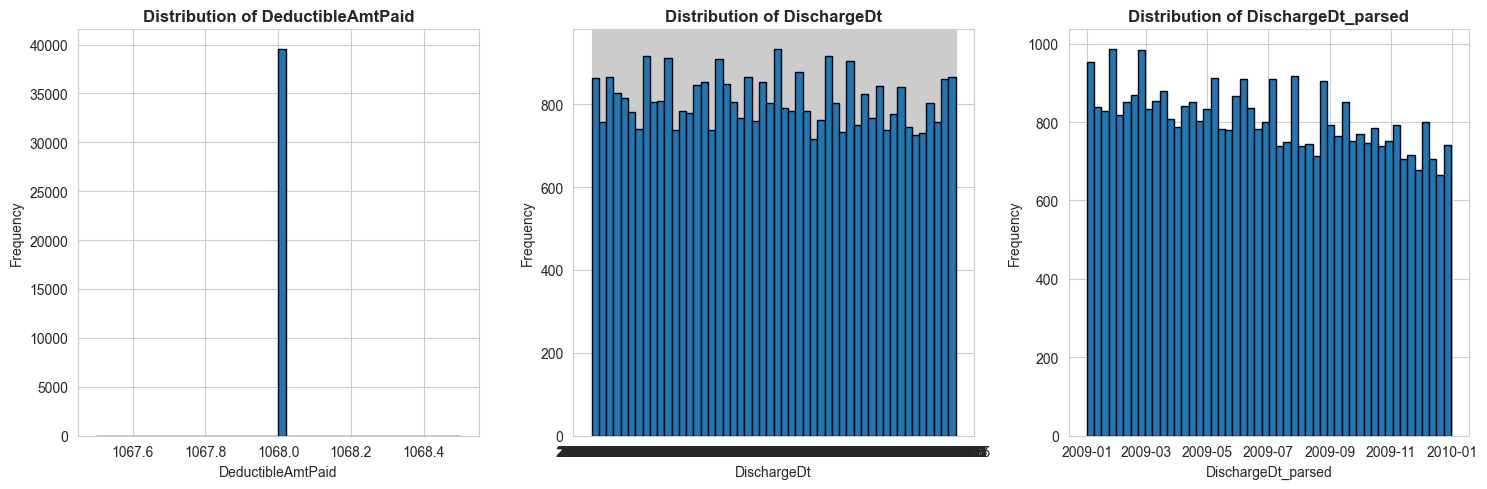

In [13]:
# Analyze inpatient claims
print("=" * 60)
print("INPATIENT CLAIMS ANALYSIS")
print("=" * 60)

# Check for financial columns (likely containing claim amounts)
financial_cols = [col for col in inpatient_df.columns if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct'])]
print(f"\nFinancial columns: {financial_cols}")

if financial_cols:
    print(f"\nFinancial statistics:")
    print(inpatient_df[financial_cols].describe())
    
    # Visualize claim amount distribution
    if len(financial_cols) > 0:
        fig, axes = plt.subplots(1, min(len(financial_cols), 3), figsize=(15, 5))
        if len(financial_cols) == 1:
            axes = [axes]
        
        for idx, col in enumerate(financial_cols[:3]):
            if idx < len(axes):
                inpatient_df[col].hist(bins=50, ax=axes[idx], edgecolor='black')
                axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()


### 5.3 Claims Analysis - Outpatient


OUTPATIENT CLAIMS ANALYSIS

Financial columns: ['DeductibleAmtPaid']

Financial statistics:
       DeductibleAmtPaid
count      517737.000000
mean            2.779233
std            15.785839
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           897.000000


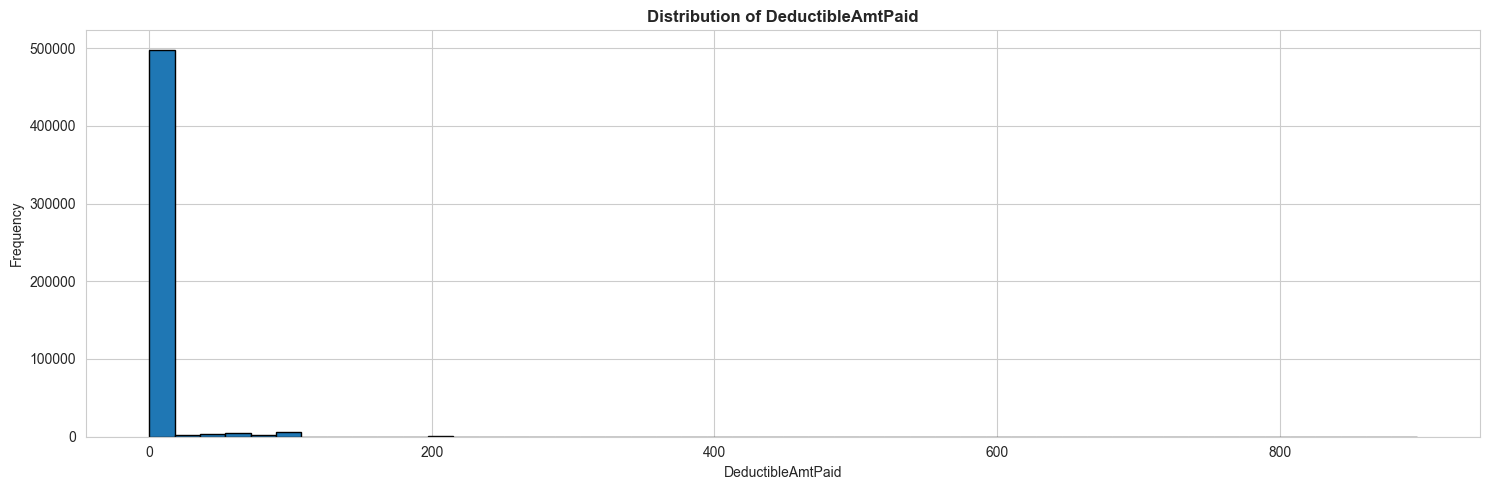

In [14]:
# Analyze outpatient claims
print("=" * 60)
print("OUTPATIENT CLAIMS ANALYSIS")
print("=" * 60)

# Check for financial columns
financial_cols_out = [col for col in outpatient_df.columns if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct'])]
print(f"\nFinancial columns: {financial_cols_out}")

if financial_cols_out:
    print(f"\nFinancial statistics:")
    print(outpatient_df[financial_cols_out].describe())
    
    # Visualize claim amount distribution
    if len(financial_cols_out) > 0:
        fig, axes = plt.subplots(1, min(len(financial_cols_out), 3), figsize=(15, 5))
        if len(financial_cols_out) == 1:
            axes = [axes]
        
        for idx, col in enumerate(financial_cols_out[:3]):
            if idx < len(axes):
                outpatient_df[col].hist(bins=50, ax=axes[idx], edgecolor='black')
                axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()


### 5.4 Comparing Fraudulent vs Legitimate Providers


In [15]:
# Merge labels with claims to compare fraudulent vs legitimate providers
print("=" * 60)
print("FRAUDULENT vs LEGITIMATE PROVIDER COMPARISON")
print("=" * 60)

# Get fraud labels
fraud_providers = set(labels_df[labels_df['PotentialFraud'] == 'Yes']['Provider'].unique())
legit_providers = set(labels_df[labels_df['PotentialFraud'] == 'No']['Provider'].unique())

print(f"\nFraudulent providers: {len(fraud_providers)}")
print(f"Legitimate providers: {len(legit_providers)}")

# Add fraud label to inpatient and outpatient data
inpatient_df['IsFraud'] = inpatient_df['Provider'].isin(fraud_providers).astype(int)
outpatient_df['IsFraud'] = outpatient_df['Provider'].isin(fraud_providers).astype(int)

# Compare claim counts per provider
inpatient_claims_per_provider = inpatient_df.groupby(['Provider', 'IsFraud']).size().reset_index(name='ClaimCount')
outpatient_claims_per_provider = outpatient_df.groupby(['Provider', 'IsFraud']).size().reset_index(name='ClaimCount')

print("\nInpatient claims per provider:")
print(inpatient_claims_per_provider.groupby('IsFraud')['ClaimCount'].describe())

print("\nOutpatient claims per provider:")
print(outpatient_claims_per_provider.groupby('IsFraud')['ClaimCount'].describe())


FRAUDULENT vs LEGITIMATE PROVIDER COMPARISON

Fraudulent providers: 506
Legitimate providers: 4904

Inpatient claims per provider:
          count       mean        std  min   25%   50%    75%    max
IsFraud                                                             
0        1652.0  10.334140  13.480442  1.0   3.0   6.0  12.00  115.0
1         440.0  53.186364  60.764805  1.0  14.0  31.0  68.25  516.0

Outpatient claims per provider:
          count        mean         std  min    25%    50%     75%     max
IsFraud                                                                   
0        4550.0   72.163297  130.897759  1.0  10.00   28.0   72.75  1244.0
1         462.0  409.943723  742.989188  1.0  43.25  121.5  423.50  8240.0


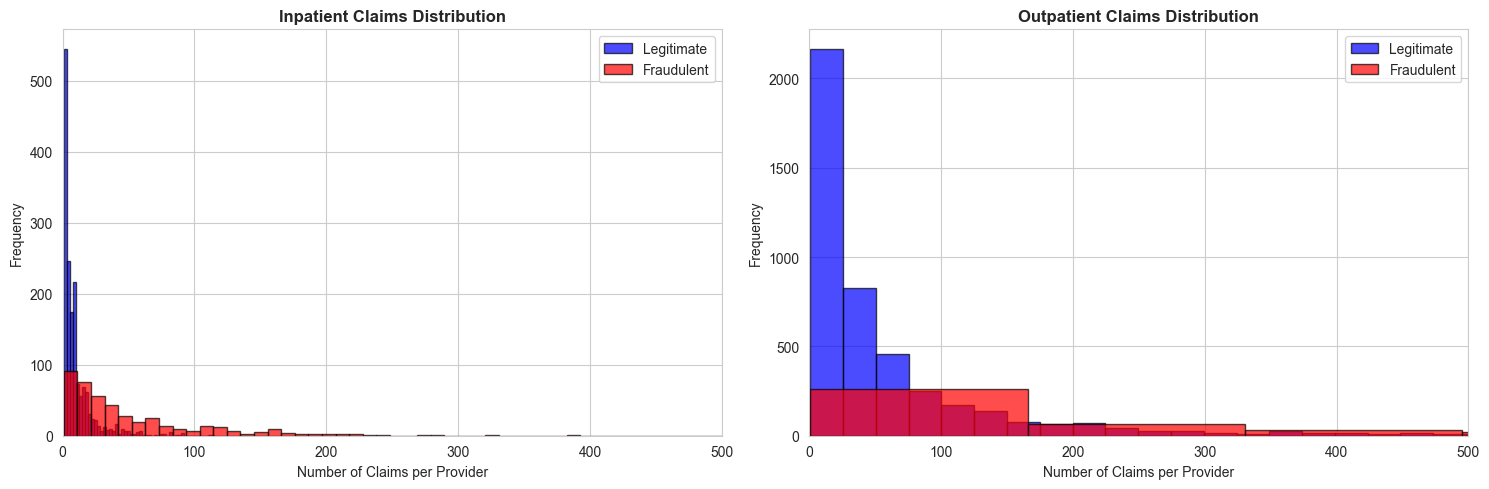

In [16]:
# Visualize claim counts comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Inpatient
fraud_inpatient = inpatient_claims_per_provider[inpatient_claims_per_provider['IsFraud'] == 1]['ClaimCount']
legit_inpatient = inpatient_claims_per_provider[inpatient_claims_per_provider['IsFraud'] == 0]['ClaimCount']

axes[0].hist(legit_inpatient, bins=50, alpha=0.7, label='Legitimate', color='blue', edgecolor='black')
axes[0].hist(fraud_inpatient, bins=50, alpha=0.7, label='Fraudulent', color='red', edgecolor='black')
axes[0].set_xlabel('Number of Claims per Provider')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Inpatient Claims Distribution', fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, min(500, max(max(fraud_inpatient), max(legit_inpatient))))

# Outpatient
fraud_outpatient = outpatient_claims_per_provider[outpatient_claims_per_provider['IsFraud'] == 1]['ClaimCount']
legit_outpatient = outpatient_claims_per_provider[outpatient_claims_per_provider['IsFraud'] == 0]['ClaimCount']

axes[1].hist(legit_outpatient, bins=50, alpha=0.7, label='Legitimate', color='blue', edgecolor='black')
axes[1].hist(fraud_outpatient, bins=50, alpha=0.7, label='Fraudulent', color='red', edgecolor='black')
axes[1].set_xlabel('Number of Claims per Provider')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Outpatient Claims Distribution', fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, min(500, max(max(fraud_outpatient), max(legit_outpatient))))

plt.tight_layout()
plt.show()


## 6. Feature Engineering - Aggregation to Provider Level

Since our target variable is at the provider level, we need to aggregate claim-level data to create provider-level features.


In [17]:
# Define aggregation strategy
print("=" * 60)
print("FEATURE ENGINEERING STRATEGY")
print("=" * 60)
print("""
We will aggregate claim-level data to provider-level features by:
1. Count features: Number of claims, unique beneficiaries, procedures, etc.
2. Sum features: Total claim amounts, reimbursed amounts, etc.
3. Mean features: Average claim amounts, average deductible, etc.
4. Ratio features: Ratios between different financial metrics
5. Temporal features: Claim patterns over time
6. Beneficiary features: Aggregated from beneficiary data linked to claims
""")


FEATURE ENGINEERING STRATEGY

We will aggregate claim-level data to provider-level features by:
1. Count features: Number of claims, unique beneficiaries, procedures, etc.
2. Sum features: Total claim amounts, reimbursed amounts, etc.
3. Mean features: Average claim amounts, average deductible, etc.
4. Ratio features: Ratios between different financial metrics
5. Temporal features: Claim patterns over time
6. Beneficiary features: Aggregated from beneficiary data linked to claims



In [18]:
# Start feature engineering
print("Creating provider-level features...")

# Get all unique providers
all_providers = labels_df['Provider'].unique()
print(f"Total providers: {len(all_providers)}")

# Initialize feature dataframe
provider_features = pd.DataFrame({'Provider': all_providers})

# Merge with labels
provider_features = provider_features.merge(labels_df, on='Provider', how='left')
provider_features['Target'] = (provider_features['PotentialFraud'] == 'Yes').astype(int)

print(f"Feature dataframe shape: {provider_features.shape}")
print(f"Columns: {list(provider_features.columns)}")


Creating provider-level features...
Total providers: 5410
Feature dataframe shape: (5410, 3)
Columns: ['Provider', 'PotentialFraud', 'Target']


### 6.1.1 Diagnosis and Procedure Diversity Features


In [19]:
# Add diagnosis diversity and procedure diversity features for inpatient (OPTIMIZED)
print("Adding diagnosis and procedure diversity features...")

# Diagnosis diversity - OPTIMIZED using efficient groupby operations
diagnosis_cols_inpatient = [col for col in inpatient_df.columns if 'Diagnosis' in col or 'DiagnosisCode' in col]
if diagnosis_cols_inpatient:
    # Use melt to stack all diagnosis columns for efficiency
    diagnosis_subset = inpatient_df[['Provider'] + [col for col in diagnosis_cols_inpatient if col in inpatient_df.columns]].copy()
    
    # Melt to convert wide format to long format (much faster than looping)
    diagnosis_melted = diagnosis_subset.melt(id_vars='Provider', var_name='DiagnosisCol', value_name='DiagnosisCode')
    diagnosis_melted = diagnosis_melted[diagnosis_melted['DiagnosisCode'].notna()]  # Remove missing values
    
    # Count unique diagnosis codes per provider (vectorized operation)
    diagnosis_diversity = diagnosis_melted.groupby('Provider')['DiagnosisCode'].nunique().reset_index()
    diagnosis_diversity.columns = ['Provider', 'Inpatient_DiagnosisDiversity']
    provider_features = provider_features.merge(diagnosis_diversity, on='Provider', how='left')
    print(f"  Added Inpatient_DiagnosisDiversity feature")

# Procedure diversity - OPTIMIZED using efficient groupby operations
procedure_cols_inpatient = [col for col in inpatient_df.columns if 'Procedure' in col or 'ProcedureCode' in col]
if procedure_cols_inpatient:
    # Use melt to stack all procedure columns
    procedure_subset = inpatient_df[['Provider'] + [col for col in procedure_cols_inpatient if col in inpatient_df.columns]].copy()
    
    # Melt to convert wide format to long format
    procedure_melted = procedure_subset.melt(id_vars='Provider', var_name='ProcedureCol', value_name='ProcedureCode')
    procedure_melted = procedure_melted[procedure_melted['ProcedureCode'].notna()]  # Remove missing values
    
    # Count unique procedure codes per provider (vectorized operation)
    procedure_diversity = procedure_melted.groupby('Provider')['ProcedureCode'].nunique().reset_index()
    procedure_diversity.columns = ['Provider', 'Inpatient_ProcedureDiversity']
    provider_features = provider_features.merge(procedure_diversity, on='Provider', how='left')
    print(f"  Added Inpatient_ProcedureDiversity feature")


Adding diagnosis and procedure diversity features...
  Added Inpatient_DiagnosisDiversity feature
  Added Inpatient_ProcedureDiversity feature


### 6.1.2 Length of Stay (LOS) Statistics


In [20]:
# Add LOS (Length of Stay) statistics for inpatient
print("Adding LOS (Length of Stay) statistics...")

if 'AdmissionDt' in inpatient_df.columns and 'DischargeDt' in inpatient_df.columns:
    # Calculate LOS if not already calculated
    if 'LOS_days' not in inpatient_df.columns:
        inpatient_df['AdmissionDt_parsed'] = pd.to_datetime(inpatient_df['AdmissionDt'], errors='coerce')
        inpatient_df['DischargeDt_parsed'] = pd.to_datetime(inpatient_df['DischargeDt'], errors='coerce')
        inpatient_df['LOS_days'] = (inpatient_df['DischargeDt_parsed'] - inpatient_df['AdmissionDt_parsed']).dt.days
    
    # Aggregate LOS statistics by provider (only valid LOS > 0)
    valid_los = inpatient_df[inpatient_df['LOS_days'] > 0].copy()
    if len(valid_los) > 0:
        los_agg = valid_los.groupby('Provider')['LOS_days'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
        los_agg.columns = ['Provider'] + [f'Inpatient_LOS_{stat}' for stat in ['mean', 'std', 'min', 'max', 'median']]
        provider_features = provider_features.merge(los_agg, on='Provider', how='left')
        print(f"  Added LOS statistics: mean, std, min, max, median")
    else:
        print("  Warning: No valid LOS values found")
else:
    print("  Warning: AdmissionDt or DischargeDt columns not found")


Adding LOS (Length of Stay) statistics...
  Added LOS statistics: mean, std, min, max, median


### 6.1 Inpatient Features


In [21]:
# Aggregate inpatient features by provider
print("Aggregating inpatient features...")

# Basic count features
inpatient_agg = inpatient_df.groupby('Provider').agg({
    'BeneID': ['count', 'nunique'],  # Total claims, unique beneficiaries
}).reset_index()
inpatient_agg.columns = ['Provider', 'Inpatient_ClaimCount', 'Inpatient_UniqueBeneficiaries']

# Identify financial columns for aggregation
inpatient_financial_cols = [col for col in inpatient_df.columns 
                           if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct', 'reimb'])]

# If financial columns exist, aggregate them (only numeric columns)
if inpatient_financial_cols:
    for col in inpatient_financial_cols:
        if col in inpatient_df.columns:
            # Only aggregate if column is numeric
            if pd.api.types.is_numeric_dtype(inpatient_df[col]):
                try:
                    col_agg = inpatient_df.groupby('Provider')[col].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
                    col_agg.columns = ['Provider'] + [f'Inpatient_{col}_{stat}' for stat in ['sum', 'mean', 'std', 'min', 'max']]
                    inpatient_agg = inpatient_agg.merge(col_agg, on='Provider', how='left')
                except Exception as e:
                    print(f"Warning: Could not aggregate column {col}: {e}")
            else:
                print(f"Warning: Skipping non-numeric financial column: {col}")

# Identify categorical/ID columns for counting unique values
categorical_cols_inpatient = [col for col in inpatient_df.columns 
                             if col not in ['Provider', 'BeneID'] and 
                             col not in inpatient_financial_cols and
                             inpatient_df[col].dtype == 'object']

for col in categorical_cols_inpatient[:5]:  # Limit to avoid too many features
    unique_count = inpatient_df.groupby('Provider')[col].nunique().reset_index()
    unique_count.columns = ['Provider', f'Inpatient_Unique_{col}']
    inpatient_agg = inpatient_agg.merge(unique_count, on='Provider', how='left')

# Merge with provider features
provider_features = provider_features.merge(inpatient_agg, on='Provider', how='left')

print(f"Inpatient features added. New shape: {provider_features.shape}")
print(f"New columns: {[col for col in provider_features.columns if col.startswith('Inpatient_')]}")



Aggregating inpatient features...
Inpatient features added. New shape: (5410, 27)
New columns: ['Inpatient_DiagnosisDiversity', 'Inpatient_ProcedureDiversity', 'Inpatient_LOS_mean', 'Inpatient_LOS_std', 'Inpatient_LOS_min', 'Inpatient_LOS_max', 'Inpatient_LOS_median', 'Inpatient_ClaimCount', 'Inpatient_UniqueBeneficiaries', 'Inpatient_InscClaimAmtReimbursed_sum', 'Inpatient_InscClaimAmtReimbursed_mean', 'Inpatient_InscClaimAmtReimbursed_std', 'Inpatient_InscClaimAmtReimbursed_min', 'Inpatient_InscClaimAmtReimbursed_max', 'Inpatient_DeductibleAmtPaid_sum', 'Inpatient_DeductibleAmtPaid_mean', 'Inpatient_DeductibleAmtPaid_std', 'Inpatient_DeductibleAmtPaid_min', 'Inpatient_DeductibleAmtPaid_max', 'Inpatient_Unique_ClaimID', 'Inpatient_Unique_ClaimStartDt', 'Inpatient_Unique_ClaimEndDt', 'Inpatient_Unique_AttendingPhysician', 'Inpatient_Unique_OperatingPhysician']


### 6.2.1 Outpatient Diagnosis and Procedure Diversity


In [22]:
# Add diagnosis and procedure diversity for outpatient (OPTIMIZED)
print("Adding outpatient diagnosis and procedure diversity...")

# Outpatient diagnosis diversity - OPTIMIZED using efficient groupby operations
diagnosis_cols_outpatient = [col for col in outpatient_df.columns if 'Diagnosis' in col or 'DiagnosisCode' in col]
if diagnosis_cols_outpatient:
    # Use melt to stack all diagnosis columns for efficiency
    diagnosis_subset_op = outpatient_df[['Provider'] + [col for col in diagnosis_cols_outpatient if col in outpatient_df.columns]].copy()
    
    # Melt to convert wide format to long format (much faster than looping)
    diagnosis_melted_op = diagnosis_subset_op.melt(id_vars='Provider', var_name='DiagnosisCol', value_name='DiagnosisCode')
    diagnosis_melted_op = diagnosis_melted_op[diagnosis_melted_op['DiagnosisCode'].notna()]  # Remove missing values
    
    # Count unique diagnosis codes per provider (vectorized operation)
    diagnosis_diversity_op = diagnosis_melted_op.groupby('Provider')['DiagnosisCode'].nunique().reset_index()
    diagnosis_diversity_op.columns = ['Provider', 'Outpatient_DiagnosisDiversity']
    provider_features = provider_features.merge(diagnosis_diversity_op, on='Provider', how='left')
    print(f"  Added Outpatient_DiagnosisDiversity feature")

# Outpatient procedure diversity - OPTIMIZED using efficient groupby operations
procedure_cols_outpatient = [col for col in outpatient_df.columns if 'Procedure' in col or 'ProcedureCode' in col]
if procedure_cols_outpatient:
    # Use melt to stack all procedure columns
    procedure_subset_op = outpatient_df[['Provider'] + [col for col in procedure_cols_outpatient if col in outpatient_df.columns]].copy()
    
    # Melt to convert wide format to long format
    procedure_melted_op = procedure_subset_op.melt(id_vars='Provider', var_name='ProcedureCol', value_name='ProcedureCode')
    procedure_melted_op = procedure_melted_op[procedure_melted_op['ProcedureCode'].notna()]  # Remove missing values
    
    # Count unique procedure codes per provider (vectorized operation)
    procedure_diversity_op = procedure_melted_op.groupby('Provider')['ProcedureCode'].nunique().reset_index()
    procedure_diversity_op.columns = ['Provider', 'Outpatient_ProcedureDiversity']
    provider_features = provider_features.merge(procedure_diversity_op, on='Provider', how='left')
    print(f"  Added Outpatient_ProcedureDiversity feature")


Adding outpatient diagnosis and procedure diversity...
  Added Outpatient_DiagnosisDiversity feature
  Added Outpatient_ProcedureDiversity feature


### 6.2 Outpatient Features


In [23]:
# Aggregate outpatient features by provider
print("Aggregating outpatient features...")

# Basic count features
outpatient_agg = outpatient_df.groupby('Provider').agg({
    'BeneID': ['count', 'nunique'],  # Total claims, unique beneficiaries
}).reset_index()
outpatient_agg.columns = ['Provider', 'Outpatient_ClaimCount', 'Outpatient_UniqueBeneficiaries']

# Identify financial columns
outpatient_financial_cols = [col for col in outpatient_df.columns 
                            if any(term in col.lower() for term in ['amount', 'cost', 'charge', 'paid', 'deduct', 'reimb'])]

# Aggregate financial columns (only numeric columns)
if outpatient_financial_cols:
    for col in outpatient_financial_cols:
        if col in outpatient_df.columns:
            # Only aggregate if column is numeric
            if pd.api.types.is_numeric_dtype(outpatient_df[col]):
                try:
                    col_agg = outpatient_df.groupby('Provider')[col].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
                    col_agg.columns = ['Provider'] + [f'Outpatient_{col}_{stat}' for stat in ['sum', 'mean', 'std', 'min', 'max']]
                    outpatient_agg = outpatient_agg.merge(col_agg, on='Provider', how='left')
                except Exception as e:
                    print(f"Warning: Could not aggregate column {col}: {e}")
            else:
                print(f"Warning: Skipping non-numeric financial column: {col}")

# Identify categorical columns
categorical_cols_outpatient = [col for col in outpatient_df.columns 
                              if col not in ['Provider', 'BeneID'] and 
                              col not in outpatient_financial_cols and
                              outpatient_df[col].dtype == 'object']

for col in categorical_cols_outpatient[:5]:  # Limit to avoid too many features
    unique_count = outpatient_df.groupby('Provider')[col].nunique().reset_index()
    unique_count.columns = ['Provider', f'Outpatient_Unique_{col}']
    outpatient_agg = outpatient_agg.merge(unique_count, on='Provider', how='left')

# Merge with provider features
provider_features = provider_features.merge(outpatient_agg, on='Provider', how='left')

print(f"Outpatient features added. New shape: {provider_features.shape}")
print(f"New columns: {[col for col in provider_features.columns if col.startswith('Outpatient_')]}")


Aggregating outpatient features...
Outpatient features added. New shape: (5410, 46)
New columns: ['Outpatient_DiagnosisDiversity', 'Outpatient_ProcedureDiversity', 'Outpatient_ClaimCount', 'Outpatient_UniqueBeneficiaries', 'Outpatient_InscClaimAmtReimbursed_sum', 'Outpatient_InscClaimAmtReimbursed_mean', 'Outpatient_InscClaimAmtReimbursed_std', 'Outpatient_InscClaimAmtReimbursed_min', 'Outpatient_InscClaimAmtReimbursed_max', 'Outpatient_DeductibleAmtPaid_sum', 'Outpatient_DeductibleAmtPaid_mean', 'Outpatient_DeductibleAmtPaid_std', 'Outpatient_DeductibleAmtPaid_min', 'Outpatient_DeductibleAmtPaid_max', 'Outpatient_Unique_ClaimID', 'Outpatient_Unique_ClaimStartDt', 'Outpatient_Unique_ClaimEndDt', 'Outpatient_Unique_AttendingPhysician', 'Outpatient_Unique_OperatingPhysician']


### 6.3 Beneficiary Features


In [24]:
# Aggregate beneficiary features by provider
print("Aggregating beneficiary features...")

# Merge beneficiary data with claims to link beneficiaries to providers
inpatient_with_beneficiary = inpatient_df[['Provider', 'BeneID']].merge(
    beneficiary_df, on='BeneID', how='left')
outpatient_with_beneficiary = outpatient_df[['Provider', 'BeneID']].merge(
    beneficiary_df, on='BeneID', how='left')

# Get numeric columns from merged dataframes (check after merge since types might change)
# Exclude Provider, BeneID and any object columns
def get_numeric_cols(df, exclude_cols):
    """Get truly numeric columns that can be aggregated"""
    numeric_cols = []
    for col in df.columns:
        if col not in exclude_cols:
            # Check if column is numeric and can be aggregated
            if pd.api.types.is_numeric_dtype(df[col]):
                # Also verify it's not all NaN or contains actual numeric values
                if df[col].notna().any():
                    numeric_cols.append(col)
    return numeric_cols

beneficiary_numeric_cols_ip = get_numeric_cols(inpatient_with_beneficiary, ['Provider', 'BeneID'])
beneficiary_numeric_cols_op = get_numeric_cols(outpatient_with_beneficiary, ['Provider', 'BeneID'])

print(f"Found {len(beneficiary_numeric_cols_ip)} numeric beneficiary columns for inpatient aggregation")
print(f"Found {len(beneficiary_numeric_cols_op)} numeric beneficiary columns for outpatient aggregation")

# Aggregate beneficiary numeric features by provider (inpatient)
if beneficiary_numeric_cols_ip:
    try:
        beneficiary_inpatient_agg = inpatient_with_beneficiary.groupby('Provider')[beneficiary_numeric_cols_ip].agg(['mean', 'std']).reset_index()
        beneficiary_inpatient_agg.columns = ['Provider'] + [f'Beneficiary_IP_{col}_{stat}' 
                                                           for col in beneficiary_numeric_cols_ip 
                                                           for stat in ['mean', 'std']]
        provider_features = provider_features.merge(beneficiary_inpatient_agg, on='Provider', how='left')
        print("Inpatient beneficiary features aggregated successfully")
    except Exception as e:
        print(f"Warning: Error aggregating inpatient beneficiary features: {e}")
        print("Skipping inpatient beneficiary features...")

# Aggregate beneficiary numeric features by provider (outpatient)
if beneficiary_numeric_cols_op:
    try:
        beneficiary_outpatient_agg = outpatient_with_beneficiary.groupby('Provider')[beneficiary_numeric_cols_op].agg(['mean', 'std']).reset_index()
        beneficiary_outpatient_agg.columns = ['Provider'] + [f'Beneficiary_OP_{col}_{stat}' 
                                                            for col in beneficiary_numeric_cols_op 
                                                            for stat in ['mean', 'std']]
        provider_features = provider_features.merge(beneficiary_outpatient_agg, on='Provider', how='left')
        print("Outpatient beneficiary features aggregated successfully")
    except Exception as e:
        print(f"Warning: Error aggregating outpatient beneficiary features: {e}")
        print("Skipping outpatient beneficiary features...")

print(f"Beneficiary features added. New shape: {provider_features.shape}")


Aggregating beneficiary features...
Found 21 numeric beneficiary columns for inpatient aggregation
Found 21 numeric beneficiary columns for outpatient aggregation
Inpatient beneficiary features aggregated successfully
Outpatient beneficiary features aggregated successfully
Beneficiary features added. New shape: (5410, 130)


### 6.4 Derived Features and Ratios


In [25]:
# Create derived features and ratios
print("Creating derived features and ratios...")

# Total claims (inpatient + outpatient)
if 'Inpatient_ClaimCount' in provider_features.columns and 'Outpatient_ClaimCount' in provider_features.columns:
    provider_features['Total_ClaimCount'] = (
        provider_features['Inpatient_ClaimCount'].fillna(0) + 
        provider_features['Outpatient_ClaimCount'].fillna(0)
    )

# Total unique beneficiaries
if 'Inpatient_UniqueBeneficiaries' in provider_features.columns and 'Outpatient_UniqueBeneficiaries' in provider_features.columns:
    provider_features['Total_UniqueBeneficiaries'] = (
        provider_features['Inpatient_UniqueBeneficiaries'].fillna(0) + 
        provider_features['Outpatient_UniqueBeneficiaries'].fillna(0)
    )

# Claims per beneficiary ratio
if 'Total_ClaimCount' in provider_features.columns and 'Total_UniqueBeneficiaries' in provider_features.columns:
    provider_features['Claims_per_Beneficiary'] = (
        provider_features['Total_ClaimCount'] / 
        (provider_features['Total_UniqueBeneficiaries'] + 1)  # Add 1 to avoid division by zero
    )

# Inpatient to outpatient ratio
if 'Inpatient_ClaimCount' in provider_features.columns and 'Outpatient_ClaimCount' in provider_features.columns:
    provider_features['IP_to_OP_Ratio'] = (
        provider_features['Inpatient_ClaimCount'].fillna(0) / 
        (provider_features['Outpatient_ClaimCount'].fillna(0) + 1)
    )

print(f"Derived features created. Final shape: {provider_features.shape}")
print(f"Total features: {len(provider_features.columns)}")


Creating derived features and ratios...
Derived features created. Final shape: (5410, 134)
Total features: 134


## 7. Handle Missing Values and Data Cleaning


In [26]:
# Check missing values in final feature set
print("=" * 60)
print("MISSING VALUES IN FINAL FEATURE SET")
print("=" * 60)

missing_summary = provider_features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print(f"\nColumns with missing values:")
    print(missing_summary)
    print(f"\nTotal missing values: {missing_summary.sum()}")
    print(f"Percentage of missing: {(missing_summary.sum() / (len(provider_features) * len(provider_features.columns))) * 100:.2f}%")
else:
    print("No missing values found!")


MISSING VALUES IN FINAL FEATURE SET

Columns with missing values:
Outpatient_ProcedureDiversity                     5263
Inpatient_LOS_std                                 3539
Inpatient_DeductibleAmtPaid_std                   3539
Beneficiary_IP_IPAnnualReimbursementAmt_std       3533
Beneficiary_IP_ChronicCond_Osteoporasis_std       3533
                                                  ... 
Outpatient_InscClaimAmtReimbursed_min              398
Beneficiary_OP_ChronicCond_Cancer_mean             398
Outpatient_InscClaimAmtReimbursed_max              398
Beneficiary_OP_ChronicCond_ObstrPulmonary_mean     398
Beneficiary_OP_State_mean                          398
Length: 127, dtype: int64

Total missing values: 258098
Percentage of missing: 35.60%


In [27]:
# Fill missing values
print("\nHandling missing values...")

# Separate feature columns (exclude Provider, PotentialFraud, Target)
feature_cols = [col for col in provider_features.columns 
                if col not in ['Provider', 'PotentialFraud', 'Target']]

# Fill missing values with 0 for count/sum features, median for mean/std features
for col in feature_cols:
    if provider_features[col].isnull().sum() > 0:
        if 'count' in col.lower() or 'sum' in col.lower() or 'unique' in col.lower():
            provider_features[col] = provider_features[col].fillna(0)
        else:
            provider_features[col] = provider_features[col].fillna(provider_features[col].median())

print("Missing values handled!")
print(f"Remaining missing values: {provider_features[feature_cols].isnull().sum().sum()}")



Handling missing values...
Missing values handled!
Remaining missing values: 0


## 8. Feature Analysis and Visualization


In [28]:
# Select numeric features for correlation analysis
numeric_features = provider_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numeric features: {len(numeric_features)}")

# Calculate correlation with target
if len(numeric_features) > 0:
    correlations = provider_features[numeric_features + ['Target']].corr()['Target'].sort_values(ascending=False)
    
    # Display top correlations
    print("\nTop 10 features most correlated with Target:")
    print(correlations.head(11)[1:])  # Exclude Target itself
    
    print("\nBottom 10 features least correlated with Target:")
    print(correlations.tail(10))


Total numeric features: 131

Top 10 features most correlated with Target:
Inpatient_Unique_ClaimEndDt             0.557127
Inpatient_Unique_ClaimStartDt           0.554549
Inpatient_DiagnosisDiversity            0.548740
Inpatient_ProcedureDiversity            0.533106
Inpatient_InscClaimAmtReimbursed_sum    0.532795
Inpatient_DeductibleAmtPaid_sum         0.525454
Inpatient_ClaimCount                    0.525393
Inpatient_Unique_ClaimID                0.525393
Inpatient_UniqueBeneficiaries           0.522256
Inpatient_LOS_max                       0.521293
Name: Target, dtype: float64

Bottom 10 features least correlated with Target:
Beneficiary_IP_ChronicCond_stroke_mean        -0.034540
Beneficiary_IP_ChronicCond_Heartfailure_std   -0.035322
Beneficiary_IP_NoOfMonths_PartACov_mean       -0.036858
Inpatient_LOS_min                             -0.047710
Beneficiary_IP_NoOfMonths_PartBCov_mean       -0.060643
Inpatient_InscClaimAmtReimbursed_min          -0.172935
Inpatient_DeductibleA

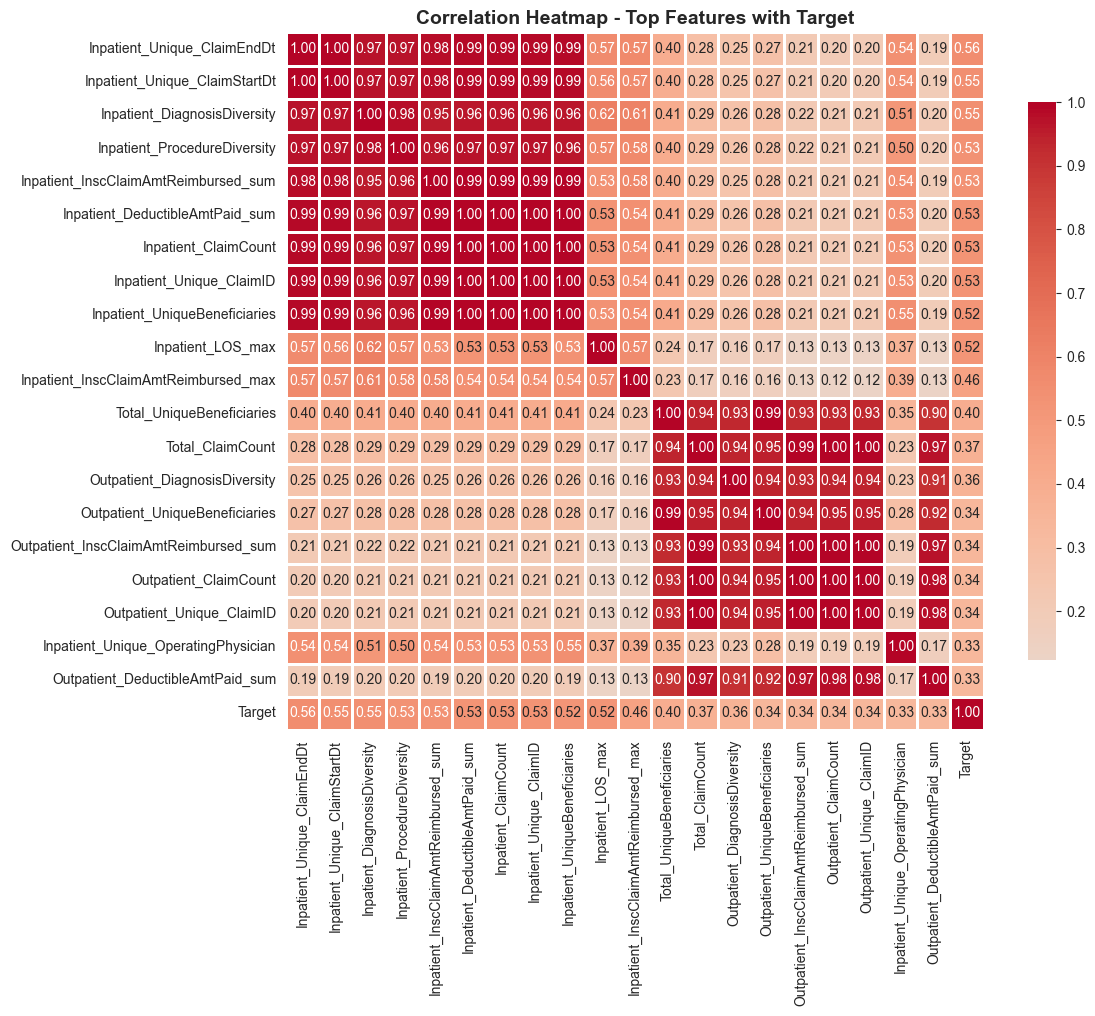

In [29]:
# Create correlation heatmap for top correlated features
if len(numeric_features) > 0:
    top_features = correlations.abs().head(21).index.tolist()[1:]  # Exclude Target, get top 20
    
    if len(top_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation_matrix = provider_features[top_features + ['Target']].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Heatmap - Top Features with Target', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


## 8.5 Geographic and Temporal Pattern Analysis

Analyzing geographic distribution and temporal patterns of fraud to identify potential regional or time-based trends.


In [ ]:
### 8.5.1 Geographic Patterns - Fraud Distribution by State

# Merge provider features with beneficiary data to get geographic information
# Get state information from beneficiaries linked to providers
provider_state = inpatient_df[['Provider', 'BeneID']].merge(
    beneficiary_df[['BeneID', 'State']], on='BeneID', how='left'
).groupby('Provider')['State'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None).reset_index()

# Merge with provider features and labels
provider_geo = provider_features[['Provider', 'Target']].merge(provider_state, on='Provider', how='left')

# Calculate fraud rate by state
if 'State' in provider_geo.columns:
    state_fraud = provider_geo.groupby('State').agg({
        'Target': ['count', 'sum', 'mean']
    }).reset_index()
    state_fraud.columns = ['State', 'Total_Providers', 'Fraud_Count', 'Fraud_Rate']
    state_fraud = state_fraud[state_fraud['Total_Providers'] >= 5]  # Filter states with at least 5 providers
    state_fraud = state_fraud.sort_values('Fraud_Rate', ascending=False)
    
    print("=" * 60)
    print("FRAUD RATE BY STATE (Top 15 States)")
    print("=" * 60)
    print(state_fraud.head(15).to_string(index=False))
    
    # Visualize fraud rate by state
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Bar plot of fraud rates
    top_states = state_fraud.head(15)
    axes[0].barh(range(len(top_states)), top_states['Fraud_Rate'].values, color='#e74c3c')
    axes[0].set_yticks(range(len(top_states)))
    axes[0].set_yticklabels(top_states['State'].values)
    axes[0].set_xlabel('Fraud Rate', fontsize=12)
    axes[0].set_title('Fraud Rate by State (Top 15)', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Scatter plot: Total providers vs Fraud rate
    axes[1].scatter(state_fraud['Total_Providers'], state_fraud['Fraud_Rate'], 
                   alpha=0.6, s=100, color='#3498db', edgecolors='black', linewidth=1)
    axes[1].set_xlabel('Total Providers', fontsize=12)
    axes[1].set_ylabel('Fraud Rate', fontsize=12)
    axes[1].set_title('Fraud Rate vs Number of Providers by State', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
### 8.5.2 Temporal Patterns - Claim Trends Over Time

# Analyze temporal patterns in claims
print("=" * 60)
print("TEMPORAL PATTERN ANALYSIS")
print("=" * 60)

# Parse claim dates and extract month/year
if 'ClaimStartDt' in inpatient_df.columns:
    inpatient_df['ClaimStartDt_parsed'] = pd.to_datetime(inpatient_df['ClaimStartDt'], errors='coerce')
    inpatient_df['ClaimMonth'] = inpatient_df['ClaimStartDt_parsed'].dt.to_period('M')
    inpatient_df['ClaimYearMonth'] = inpatient_df['ClaimStartDt_parsed'].dt.strftime('%Y-%m')

if 'ClaimStartDt' in outpatient_df.columns:
    outpatient_df['ClaimStartDt_parsed'] = pd.to_datetime(outpatient_df['ClaimStartDt'], errors='coerce')
    outpatient_df['ClaimMonth'] = outpatient_df['ClaimStartDt_parsed'].dt.to_period('M')
    outpatient_df['ClaimYearMonth'] = outpatient_df['ClaimStartDt_parsed'].dt.strftime('%Y-%m')

# Merge fraud labels to claims
inpatient_df['IsFraud'] = inpatient_df['Provider'].isin(
    labels_df[labels_df['PotentialFraud'] == 'Yes']['Provider'].unique()
).astype(int)

outpatient_df['IsFraud'] = outpatient_df['Provider'].isin(
    labels_df[labels_df['PotentialFraud'] == 'Yes']['Provider'].unique()
).astype(int)

# Aggregate claims by month and fraud status
if 'ClaimYearMonth' in inpatient_df.columns:
    inpatient_monthly = inpatient_df.groupby(['ClaimYearMonth', 'IsFraud']).agg({
        'ClaimID': 'count',
        'InscClaimAmtReimbursed': 'sum'
    }).reset_index()
    inpatient_monthly.columns = ['Month', 'IsFraud', 'ClaimCount', 'TotalAmount']
    inpatient_monthly['FraudStatus'] = inpatient_monthly['IsFraud'].map({0: 'Legitimate', 1: 'Fraudulent'})
    
    # Visualize temporal trends
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Claim counts over time
    for fraud_status in ['Legitimate', 'Fraudulent']:
        data = inpatient_monthly[inpatient_monthly['FraudStatus'] == fraud_status]
        axes[0].plot(data['Month'], data['ClaimCount'], marker='o', 
                    label=fraud_status, linewidth=2, markersize=6)
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel('Number of Claims', fontsize=12)
    axes[0].set_title('Inpatient Claims Over Time by Fraud Status', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Total claim amounts over time
    for fraud_status in ['Legitimate', 'Fraudulent']:
        data = inpatient_monthly[inpatient_monthly['FraudStatus'] == fraud_status]
        axes[1].plot(data['Month'], data['TotalAmount'], marker='o', 
                    label=fraud_status, linewidth=2, markersize=6)
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Total Claim Amount ($)', fontsize=12)
    axes[1].set_title('Total Inpatient Claim Amounts Over Time by Fraud Status', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nTemporal Pattern Summary:")
    print(f"Date range: {inpatient_df['ClaimStartDt_parsed'].min()} to {inpatient_df['ClaimStartDt_parsed'].max()}")
    print(f"\nMonthly average claims - Legitimate: {inpatient_monthly[inpatient_monthly['IsFraud'] == 0]['ClaimCount'].mean():.0f}")
    print(f"Monthly average claims - Fraudulent: {inpatient_monthly[inpatient_monthly['IsFraud'] == 1]['ClaimCount'].mean():.0f}")


## 9. Save Processed Features


In [30]:
# Save the processed feature set
output_path = Path('../data/provider_level_features.csv')

# Define feature columns (exclude identifier and target columns)
feature_cols = [col for col in provider_features.columns 
                if col not in ['Provider', 'PotentialFraud', 'Target']]

provider_features.to_csv(output_path, index=False)

print(f"Processed features saved to {output_path}")
print(f"Final feature set shape: {provider_features.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature columns saved for use in modeling:")
print(feature_cols[:10], "..." if len(feature_cols) > 10 else "")


Processed features saved to ../data/provider_level_features.csv
Final feature set shape: (5410, 134)
Number of features: 131

Feature columns saved for use in modeling:
['Inpatient_DiagnosisDiversity', 'Inpatient_ProcedureDiversity', 'Inpatient_LOS_mean', 'Inpatient_LOS_std', 'Inpatient_LOS_min', 'Inpatient_LOS_max', 'Inpatient_LOS_median', 'Inpatient_ClaimCount', 'Inpatient_UniqueBeneficiaries', 'Inpatient_InscClaimAmtReimbursed_sum'] ...
